In [43]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from ironsilicate import IronSilicateEOS
from scipy import interpolate
from scipy import integrate

This reads the PhotometryPlanetRadiiSamplesRedo.csv file that I generated in USPRadiusDistribution.ipynb. It has 1000 radius samples for each USP planet. I make them all into a giant 71000-sample list that I can then slice for each planet.

In [44]:
periodsamples = []
radiisamples = []
kepids = []

## get 1000 planetary radius samples per planet, set up period array
with open('PhotometryPlanetRadiiSamplesRedo.csv') as File:
    reader = csv.reader(File, delimiter=',')
    rownum = 0
    for row in reader:
        kepids.append(int(row[0]))
        samplelist = list(str(row[1]).split(','))
        samplelist[0] = samplelist[0][1:] # remove brackets
        samplelist[len(samplelist)-1] = samplelist[len(samplelist)-1][:-1] #remove brackets
        sampleslist = [float(i) for i in samplelist]
        radiisamples = radiisamples + sampleslist
        rownum += 1

In [47]:
print(len(kepids))
print(len(radiisamples))

71
71000


Set up spherical integration

In [48]:
G = 6.67e-11
epsilon = 0.00001

Emass = 5.972e24 ## Earth mass
Erad = 6371000 ## Earth radius

P_cmb = np.logspace(8., 14., 32)
P_max_hat = np.logspace(0., 2., 32)


cmfarray = np.zeros((len(P_cmb), len(P_max_hat)))
crfarray = np.zeros_like(cmfarray)
planetmass = np.zeros_like(cmfarray)
planetrad = np.zeros_like(cmfarray)

In [49]:
Pcarr = []
rhos = []

for i in range(len(P_cmb)):
    for j in range(1, len(P_cmb)):
        
        Pcmb = P_cmb[i]
        eos = IronSilicateEOS(Pcmb, P_max_hat[j])
        Pc = eos.P_max
        Pcarr.append(Pc)
        
        def rho(P):
            return eos.eqnOfState(P)
        
        
        m0 = (4/3) * np.pi * rho(Pc) * (epsilon**3) ## initial mass
        P0 = Pc - (2/3) * np.pi * G * (rho(Pc)**2) * (epsilon**2) ## initial pressure
        
         ## change of variables where q = ln(P)
        def dmdq(q, m, r):
            P = np.exp(q)
            g = (G * m) / (r**2)
            return (-4 * P * np.pi * (r**2)) / g
        
        def drdq(q, m, r):
            P = np.exp(q)
            g = (G * m) / (r**2)
            return -P / (rho(P) * g)
            
        def fun(q, x):
            m, r = x
            return dmdq(q, m, r), drdq(q, m, r)
        
        q0 = np.log(P0)
        
        sol = integrate.solve_ivp(fun, t_span = (q0, 0), y0 = [m0, epsilon], method = 'LSODA', rtol = 0.5e-3, atol = 0.5e-6, max_step = .1)

        ## LSODA is the only integration method that works for this order of magnitude
        
        pressure = np.exp(sol.t)
        masses = sol.y[0]
        radii = sol.y[1]
        
        if i == 25 and j == 25:
             pre = np.exp(sol.t)
             mas = sol.y[0]
             rad = sol.y[1]
        
        

        # interpolate masses
        s = interpolate.interp1d(pressure, masses)
        coremass = s(Pcmb) # mass of core
        totalmass = s(1) # total planet mass
        cmf = coremass / totalmass # core mass fraction
        cmfarray[i][j] = cmf
        planetmass[i][j] = totalmass / Emass # in Earth masses
        
        # interpolate radii
        r = interpolate.interp1d(pressure, radii)
        corerad = r(Pcmb) # radius of core
        totalrad = r(1) # total radius
        crf = corerad / totalrad # core radius fraction
        crfarray[i][j] = crf
        planetrad[i][j] = totalrad / Erad # in Earth radii


Set up and flatten arrays for interpolation

In [50]:
Pcmbarray = np.zeros((len(P_cmb), len(P_cmb)))
Pmaxhatarray = np.zeros((len(P_cmb), len(P_cmb)))
for i in range(len(P_cmb)):
    for j in range(len(P_cmb)):
        Pcmbarray[i][j] = P_cmb[i]
        Pmaxhatarray[i][j] = P_max_hat[j]

In [51]:
flatrad = planetrad.flatten()
flatcmf = cmfarray.flatten()
flatPcmb = Pcmbarray.flatten()
flatPmaxhat = Pmaxhatarray.flatten()

getpcmb = interpolate.LinearNDInterpolator((flatrad, flatcmf), flatPcmb)
getpmaxhat = interpolate.LinearNDInterpolator((flatrad, flatcmf), flatPmaxhat)

getmass = interpolate.RegularGridInterpolator((P_cmb, P_max_hat), planetmass)

Interpolate massses. If the interpolation doesn't work for a sample, I put in a placeholder to maintain the order when slicing.

In [74]:
earthmasssamples = []
i = 0
for radsample in radiisamples:
    try:
        earthmasssamples.append(getmass((getpcmb(radsample, 0.33), getpmaxhat(radsample, 0.33))))
        i = i + 1
    except:
        print("could not interpolate for sample", i)
        earthmasssamples.append('nan')
        i = i + 1
    

could not interpolate for sample 36408
could not interpolate for sample 36759


In [76]:
len(earthmasssamples)
print(earthmasssamples[23])

5.851136303387958


In [81]:
meanearthmasses = []
eartherr = []


file = open('PlanetMassSamples.csv', 'w')
with file:
    writer = csv.writer(file)
    for i in range(0, (len(earthmasssamples) // 1000)):
        list1 = []
        list1 = earthmasssamples[(1000*i) : (1000*(i+1)) - 1]
        for f in list1:
            if f == 'nan':
                list1.remove(f)
        meanearthmasses.append(np.percentile(list1, 50))
        eartherr.append(np.std(list1))
        row = [kepids[i]]
        for k in range(0, len(list1)):
            row.append(list1[k])
        writer.writerow(row)

In [82]:
print(meanearthmasses)

[4.7683790533482746, 1.7088660781625495, 2.7106098405184724, 2.8669070460287491, 2.1661611399167895, 3.0952524569730113, 4.0543118993123208, 1.6656981587761086, 3.262309838109875, 1.9153542272585162, 3.8412663761174373, 1.9715394301419105, 3.9210230807892632, 3.297873123275985, 1.9857304429113727, 2.0377957645741183, 7.0935926374567853, 6.4288169622796758, 4.7098555929190384, 2.3022384090653003, 8.4486669818797324, 3.2814845108356283, 4.2565073552453869, 1.6733574735203811, 6.4986879259919181, 8.0727497742449916, 2.693177712786702, 5.1598590857001776, 4.4010445571179719, 1.7314923763340477, 0.73820471543471022, 0.75537035463882241, 5.2225960803520266, 1.4901097030463519, 2.6915002800871695, 0.95824767679245249, 30.050868129111876, 1.6792678519883686, 11.238202992465141, 1.7967154222432797, 0.74285520015319861, 1.1795402392007353, 4.3654057332236995, 0.35757111405517328, 3.1540897483953954, 4.6508825174225752, 7.7331612154715916, 5.4930891059085649, 3.1598709129938607, 2.468785808965656

In [83]:
print(eartherr)

[1.4783213644851587, 0.21052165753743132, 0.2911494315725256, 0.28248385712615109, 0.13956611001839728, 0.62669670601751437, 0.88505412496937474, 0.21546422347517608, 0.68148416198395856, 0.42581283372697287, 0.25614159793121061, 0.3205411216331141, 0.50599859437934191, 0.22025710184177719, 0.16197250255949083, 0.44248663041505587, 1.150171050391124, 0.81986493787288339, 0.35768091397261281, 0.29030275503506686, 0.86741379911974881, 0.40340270012909085, 0.84917037357064895, 0.22891812090990638, 2.3956064589945321, 1.3930751327405595, 0.16809799219192595, 0.75488659607168829, 0.28625378438687638, 0.2274734376014392, 0.24137093312309718, 0.14280140733989891, 0.86355006229451992, 0.26771389225140912, 1.3227879764911847, 0.13002450834852947, 34.808442538055935, 0.23724329830248261, 2.5449665762988354, 0.18596132195257284, 0.054889612036587418, 0.32742890710204348, 0.71101036912384763, 0.033419552664873196, 0.78451357178438974, 0.29461148782983027, 0.90040625515496031, 0.36628343697527088, 

In [88]:
meanplanradband = [1.5142207897134599, 1.1436702581725311, 1.29995494508817, 1.3189668428623589, 1.2269233123544596, 1.3416469177901493, 1.4501086309196631, 1.1346210885160928, 1.3678308145394535, 1.1773182912719149, 1.4290130565850703, 1.1924524835284092, 1.4377185513117101, 1.3778832575370645, 1.1987523431558333, 1.2031537496435152, 1.6789372289268041, 1.6367597521676016, 1.5102166858962964, 1.2450243555135487, 1.7554218547394591, 1.3750204896572571, 1.4763165953082957, 1.1374076117298841, 1.6579424766739201, 1.7474079535815623, 1.2976710643762763, 1.5469721327227073, 1.4803792515077325, 1.1485935543428036, 0.91107113014034191, 0.90912534283711122, 1.5575626745682334, 1.1016976539308982, 1.306567461499029, 0.97216101853985515, 2.3659198651407789, 1.1388767324032376, 1.8878774237581295, 1.1603625846498211, 0.90433911227498831, 1.0330717061012351, 1.4773091465919181, 0.72919497667200817, 1.3558223565388077, 1.5039103713589141, 1.7185699399360876, 1.5759094919342289, 1.3535027097987864, 1.2676025968602689, 1.6999474483312145, 1.7232645141015186, 1.4375272444998766, 1.2675926110963895, 1.0322004078256348, 1.742165191417018, 1.5358602614962091, 1.4630747310708188, 1.3776544531211727, 1.0864475036950445, 1.2169836268301546, 1.4158706344921796, 1.025515766195459, 2.5964514405645982, 0.98803480896675566, 1.3933339279057437, 1.7206936810871374, 1.5010015006680679, 1.4465641351682894, 1.0878734373223826, 1.5076561842415757]

radsss = []
massss = []
cmfsss = []

for i in range(len(planetrad[0])):
    for j in range(len(planetrad)):
        radsss.append(planetrad[i][j])
        massss.append(planetmass[i][j])
        cmfsss.append(cmfarray[i][j])

/Users/anasofiauzsoy/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


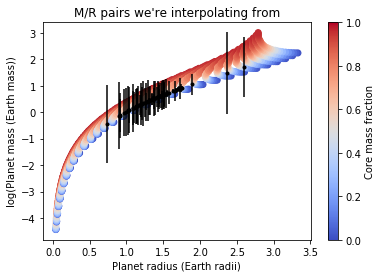

In [104]:
cm = plt.cm.get_cmap('coolwarm')
sc = plt.scatter(radsss, np.log10(massss), c = cmfsss, vmin = 0., vmax = 1., cmap = cm)
plt.plot(meanplanradband, np.log10(meanearthmasses),'k.')
plt.errorbar(meanplanradband, np.log10(meanearthmasses),ls= 'none',yerr = np.log10(eartherr), ecolor = 'k')
plt.colorbar(sc, label = "Core mass fraction")
plt.xlabel("Planet radius (Earth radii)")
plt.ylabel("log(Planet mass (Earth mass))")
plt.title("M/R pairs we're interpolating from")
plt.show()

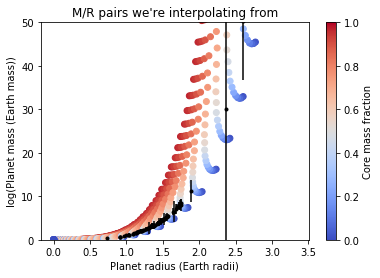

In [105]:
cm = plt.cm.get_cmap('coolwarm')
sc = plt.scatter(radsss, massss, c = cmfsss, vmin = 0., vmax = 1., cmap = cm)
plt.plot(meanplanradband, meanearthmasses,'k.')
plt.errorbar(meanplanradband, meanearthmasses, ls= 'none',yerr = eartherr, ecolor = 'k')
plt.colorbar(sc, label = "Core mass fraction")
plt.xlabel("Planet radius (Earth radii)")
plt.ylabel("log(Planet mass (Earth mass))")
plt.title("M/R pairs we're interpolating from")
plt.ylim(0, 50)
plt.show()